In [25]:
import os
import PIL
import glob
import time
import imageio
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as pt

from glob import glob
from IPython import display
from tensorflow.keras import layers, losses
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

from typing import Iterable, List, Tuple, Any

In [2]:
tf.__version__

'2.5.0-dev20210130'

We will be attempting to style the facades dataset to match vangogh's style

In [3]:
train_dir: str = 'trainA'
test_dir: str = 'testA'
style_dir: str = 'data/vangogh2photo'
image_dir: str = 'data/facades'

## Utils
---

In [4]:
def list_files(directory: str, search: Iterable) -> List[str]:
    """
    list files
    """
    if isinstance(search, str):
        search = [search]

    output: List[str] = []
    for term in search:
        for filepath in glob(os.path.join(directory, term)):
            output.append(filepath)

    return output

In [5]:
def load_random_image(directory: str, search: Iterable) -> np.ndarray:
    filepaths = list_files(directory, search)
    rand_index = np.random.randint(0, high=len(filepaths))
    return np.asarray(PIL.Image.open(filepaths[rand_index]))

---

## Random Images From the Style and Image Datasets

In [6]:
random_image = load_random_image(os.path.join(style_dir, train_dir), "*.jpg")

In [7]:
random_image.shape

(256, 256, 3)

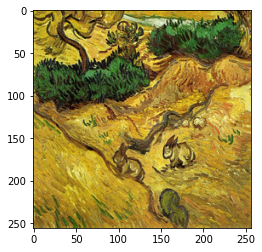

In [8]:
pt.imshow(random_image)

In [9]:
random_image = load_random_image(os.path.join(image_dir, train_dir), "*.jpg")

In [10]:
random_image.shape

(256, 256, 3)

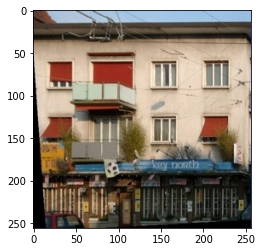

In [11]:
pt.imshow(random_image)

In [16]:
BUFFER_SIZE=64
BATCH_SIZE=64

In [17]:
dgen_params = dict(
    rescale           =  1./255,
    shear_range       =  0.0,
    zoom_range        =  0.0,
    horizontal_flip   =  True,
    brightness_range  =  (0.7, 1.2)
)

gen_params = dict(
    target_size       =  (256, 256),
    batch_size        =  BATCH_SIZE,
    class_mode        =  'binary',
    color_mode        =  'rgb'
)

In [18]:
style_train_dgen = tf.keras.preprocessing.image.ImageDataGenerator(
    **dgen_params
)
image_train_dgen = tf.keras.preprocessing.image.ImageDataGenerator(
    **dgen_params
)

style_train_gen = style_train_dgen.flow_from_directory(
    os.path.join(style_dir),
    **gen_params
)
image_train_gen = image_train_dgen.flow_from_directory(
    os.path.join(image_dir),
    **gen_params
)

Found 803 images belonging to 3 classes.
Found 507 images belonging to 3 classes.


In [20]:
style_dataset = tf.data.Dataset.from_generator(lambda: style_train_gen, (tf.float32, tf.float32)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [21]:
image_dataset = tf.data.Dataset.from_generator(lambda: image_train_gen, (tf.float32, tf.float32)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Model Definitions
---

In the original GANILLA implementation they made use of a modified ResNet18,
so we will do something similar

This starts with an implementation of ResNet: https://medium.com/@divyanshuraj.6815/learn-to-code-in-tensorflow2-part2-b1c448abbf1e

In [54]:
class Autoencoder(tf.keras.models.Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.latent_dim = 128
        self.encoder = self._make_encoder_model()
        self.decoder = self._make_decoder_model()
        
    def call(self, x, training: bool = None) -> Tuple[Any]:
        encoded = self.encoder(x, training=training)
        decoded = self.decoder(encoded, training=training)
        
        return encoded, decoded
    
    def _make_encoder_model(self):
        model = tf.keras.models.Sequential()
        
        inp = layers.Input((256, 256, 3))
        model.add(tf.keras.applications.ResNet50V2(
            include_top=False,
            weights='imagenet',
            input_tensor=inp,
            input_shape=(256, 256, 3),
            pooling='avg'
        ))
        
        model.add(layers.Dense(self.latent_dim, use_bias=False, name='latent_output'))
        
        for layer in model.layers:
            if layer.name != 'latent_output':
                layer.trainable = False
                
        return model
    
    def _make_decoder_model(self):
        inp = layers.Input(shape=(4*4*8))

        x = layers.Reshape((4, 4, 8))(inp)
        
        x = layers.Conv2DTranspose(8, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
        assert tuple(x.get_shape()) == (None, 8, 8, 8)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)
        
        x = layers.Conv2DTranspose(7, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
        assert tuple(x.get_shape()) == (None, 16, 16, 7)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        x = layers.Conv2DTranspose(6, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
        assert tuple(x.get_shape()) == (None, 32, 32, 6)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        x = layers.Conv2DTranspose(5, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
        assert tuple(x.get_shape()) == (None, 64, 64, 5)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        x = layers.Conv2DTranspose(4, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
        assert tuple(x.get_shape()) == (None, 128, 128, 4)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)
        
        x = layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
        assert tuple(x.get_shape()) == (None, 256, 256, 3)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU()(x)

        return tf.keras.models.Model(inputs=inp, outputs=x)

In [55]:
autoencoder = Autoencoder()

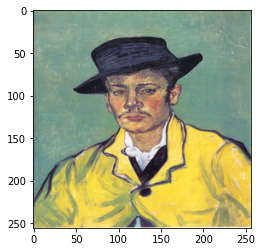

In [56]:
random_style_image = load_random_image(os.path.join(style_dir, train_dir), "*.jpg")
pt.imshow(random_style_image)

In [57]:
encoded_random_style_image, decoded_random_style_image = autoencoder(random_style_image.reshape((1, 256, 256, 3)), training=False)

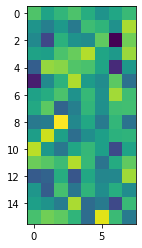

In [58]:
pt.imshow(encoded_random_style_image.numpy().reshape((16, -1)))

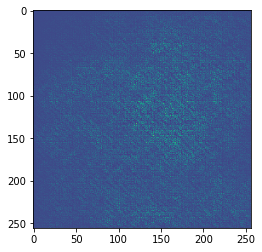

In [59]:
pt.imshow(decoded_random_style_image.numpy()[0, :, :, 0])